## Question 6. Are Certain Actors More Likely to Be Typecast into Specific Archetypes?

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [31]:
#ignore
archetype_data = pd.read_csv('data/enriched/persona_identification/archetype_predictions_joined.csv')
character_data = pd.read_csv('data/MovieSummaries/character_processed.csv')
character_data = character_data.rename(columns={
    'Wikipedia movie ID': "wikipedia_movie_id",
    'Freebase movie ID': "fb_movie_id",
    'Character name': "character_name",
    'Actor gender': "actor_gender",
    'Actor height (in meters)': "actor_height",
    'Actor ethnicity (Freebase ID)': "fb_actor_eth_id",
    'Actor name': "actor_name",
    'Freebase character/actor map ID': "fb_char_actor_map_id",
    'Freebase character ID': "fb_char_id",
    'Freebase actor ID': "fb_actor_id",
})
character_data = character_data.drop_duplicates(subset=["fb_movie_id", "fb_actor_id", "character_name"])

df = pd.merge(
    archetype_data, 
    character_data, 
    how="inner", 
    left_on=["actor_fb_id", "movie_fb_id", "character_name"], 
    right_on=["fb_actor_id", "fb_movie_id", "character_name"]
)
df = df.rename(columns={'original_response': "archetype"})
df.head(3)

,Unnamed: 0,prediction,archetype,character_name,movie_name,movie_fb_id,actor_fb_id,model,wikipedia_movie_id,fb_movie_id,...,actor_height,fb_actor_eth_id,actor_name,fb_char_actor_map_id,fb_char_id,fb_actor_id,actor_date_of_birth,movie_release_date,ethn_name,race
0,0,Mentor / Wise Guide,Mentor / Wise Guide,Umeko Tsuda,Leonie,/m/05zr2p5,/m/0c7tjc,gpt-3.5-turbo,22611767,/m/05zr2p5,...,1.540,NaN,Mieko Harada,/m/0fpvy15,/m/0n37v4l,/m/0c7tjc,1958-12-26,2010-01-01,NaN,NaN
1,1,Rogue / Trickster / Con Artist,Rogue / Trickster / Con Artist,'2-Gun' Gertie Baxter,Roxie Hart,/m/026l5ym,/m/049wny,gpt-4o,7950950,/m/026l5ym,...,1.630,NaN,Iris Adrian,/m/06plhhz,/m/06plhcj,/m/049wny,1912-05-29,1942-02-20,NaN,NaN
2,2,Rogue / Trickster / Con Artist,Rogue / Trickster / Con Artist,'A.J.' Furnival,The Groom Wore Spurs,/m/05nszz2,/m/0h7dd,gpt-3.5-turbo,33509255,/m/05nszz2,...,1.638,NaN,Ginger Rogers,/m/05ns_30,/m/0h1pslb,/m/0h7dd,1911-07-16,1951-01-01,NaN,NaN


To answer this question let's find the actors sorted in a way of how many roles (characters) they've played

In [33]:
unique_roles_counts = (
    df.groupby('actor_name')['character_name']
    .nunique()
    .reset_index()
)

unique_roles_counts.columns = ['actor_name', 'unique_character_count']
sorted_actors = unique_roles_counts.sort_values(by='unique_character_count', ascending=False)
sorted_actors.head(10) 

,actor_name,unique_character_count
12536,John Wayne,129
16022,Mammootty,127
18105,Mohanlal,119
976,Amitabh Bachchan,111
17255,Mel Blanc,97
17415,Michael Caine,86
986,Amrish Puri,76
1605,Anthony Quinn,72
4456,Christopher Walken,70
21410,Robert Duvall,68


Now let's check how many actors have 10 or more roles played 

In [34]:
actors_with_10_plus_roles = sorted_actors[sorted_actors['unique_character_count'] >= 10]
number_of_actors_10_plus = len(actors_with_10_plus_roles)
print(f'Number of actors with 10 or more unique roles: {number_of_actors_10_plus}')

Number of actors with 10 or more unique roles: 1744


This is a sufficient amount of actors to analyze. Now let's make a distribution of archetypes for each actor

In [37]:
filtered_df = df[df['actor_name'].isin(actors_with_10_plus_roles['actor_name'])]
filtered_df.head(2)

,Unnamed: 0,prediction,archetype,character_name,movie_name,movie_fb_id,actor_fb_id,model,wikipedia_movie_id,fb_movie_id,...,actor_height,fb_actor_eth_id,actor_name,fb_char_actor_map_id,fb_char_id,fb_actor_id,actor_date_of_birth,movie_release_date,ethn_name,race
2,2,Rogue / Trickster / Con Artist,Rogue / Trickster / Con Artist,'A.J.' Furnival,The Groom Wore Spurs,/m/05nszz2,/m/0h7dd,gpt-3.5-turbo,33509255,/m/05nszz2,...,1.638,NaN,Ginger Rogers,/m/05ns_30,/m/0h1pslb,/m/0h7dd,1911-07-16,1951-01-01,NaN,NaN
4,4,Warrior / Vigilante,Warrior / Vigilante,'Baby Face' Martin,Dead End,/m/0gnrt,/m/03n6r,gpt-4o,61525,/m/0gnrt,...,1.740,/m/07mqps,Humphrey Bogart,/m/0jx1fs,/m/0gz4xcm,/m/03n6r,1899-12-25,1937-01-01,Dutch,European


In [40]:
archetype_distribution = (
    filtered_df.groupby(['actor_name', 'archetype'])
    .size()
    .reset_index(name='count')
)
archetype_distribution.head(3)

,actor_name,archetype,count
0,A. J. Cook,Caregiver / Healer,1
1,A. J. Cook,Innocent / Vulnerable,2
2,A. J. Cook,Love Interest / Romantic Partner,2


Now let's normalize the counts:

In [41]:
total_roles_per_actor = (
    archetype_distribution.groupby('actor_name')['count']
    .sum()
    .reset_index()
)
total_roles_per_actor.columns = ['actor_name', 'total_roles']

archetype_distribution = pd.merge(archetype_distribution, total_roles_per_actor, on='actor_name')
archetype_distribution['probability'] = archetype_distribution['count'] / archetype_distribution['total_roles']

archetype_distribution.head(3)

,actor_name,archetype,count,total_roles,probability
0,A. J. Cook,Caregiver / Healer,1,10,0.1
1,A. J. Cook,Innocent / Vulnerable,2,10,0.2
2,A. J. Cook,Love Interest / Romantic Partner,2,10,0.2


Now we can visualize the archetype distribution for each actor using a bar plot

In [51]:
def plot_archetype_distribution(actor_name, archetype_distribution_df):
    actor_data = archetype_distribution_df[archetype_distribution_df['actor_name'] == actor_name]

    if actor_data.empty:
        print(f"No data found for actor: {actor_name}")
        return

    plt.figure(figsize=(10, 6))
    sns.barplot(data=actor_data, x='archetype', y='probability', hue='archetype', dodge=False)

    plt.title(f'Archetype Distribution for {actor_name}', fontsize=16)
    plt.xlabel('Archetype', fontsize=14)
    plt.ylabel('Probability', fontsize=14)
    plt.xticks(rotation=45)
    plt.ylim(0, 1)  
    plt.tight_layout()
    plt.show()

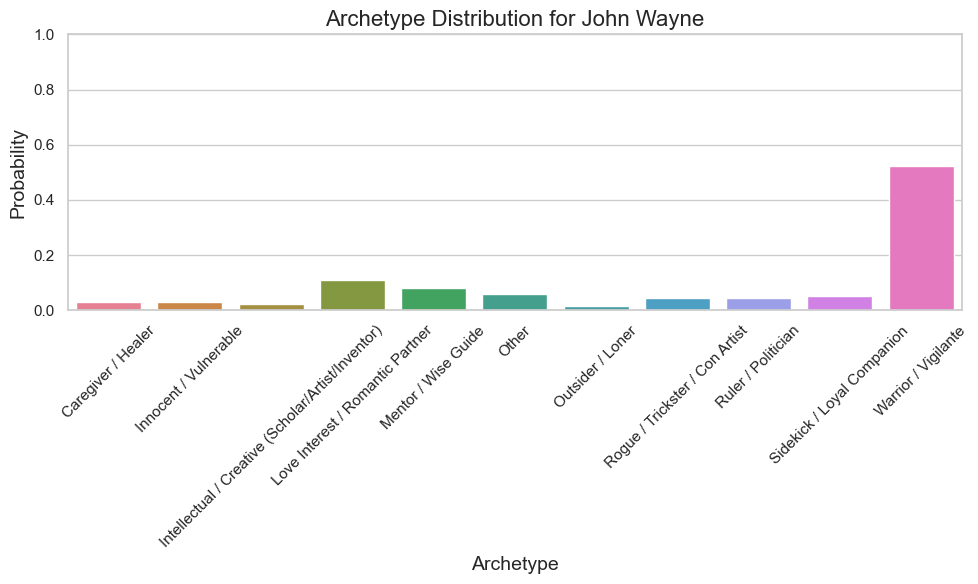

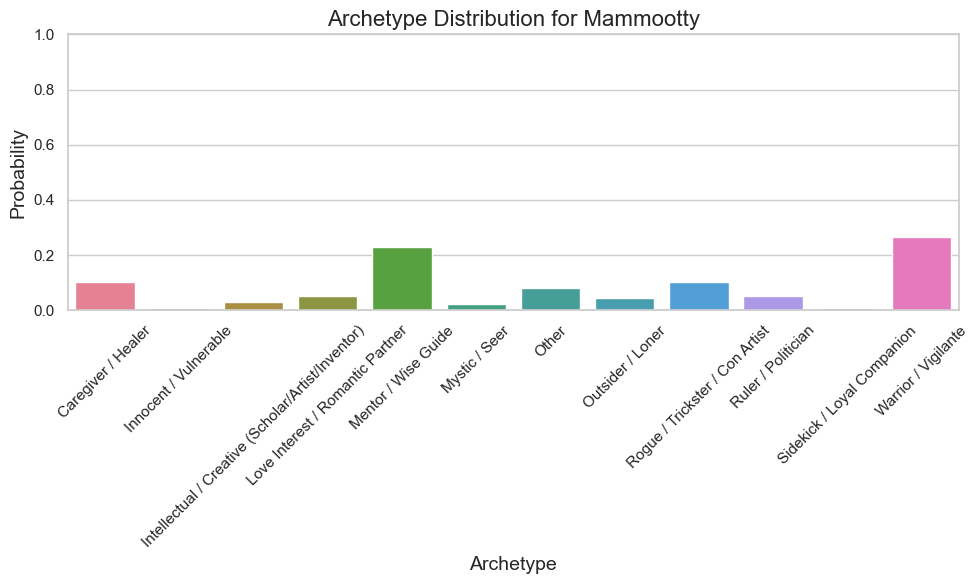

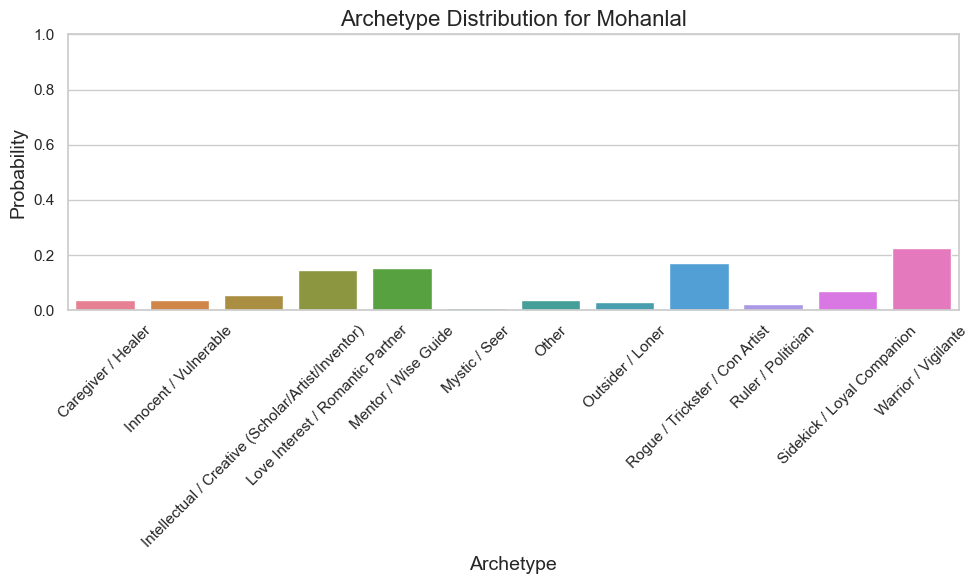

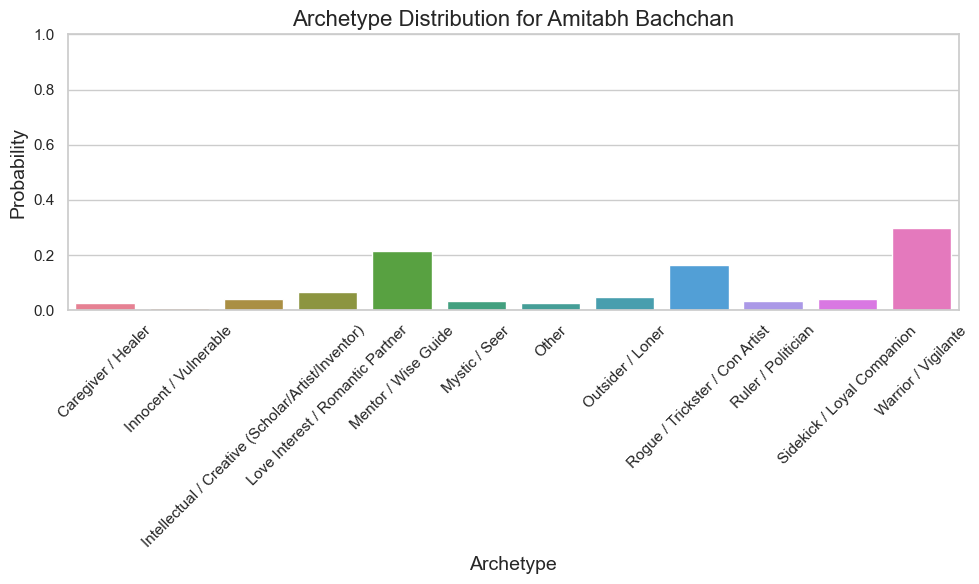

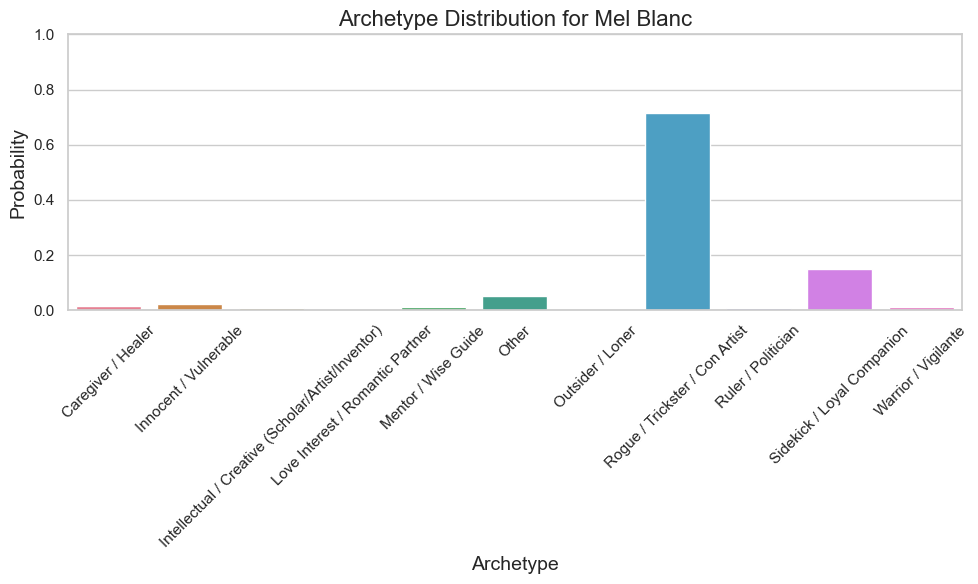

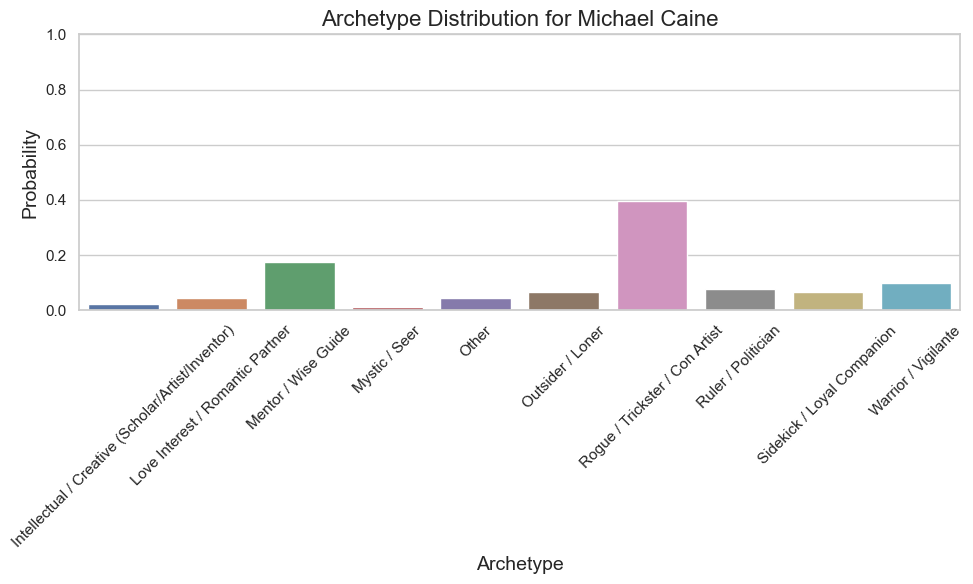

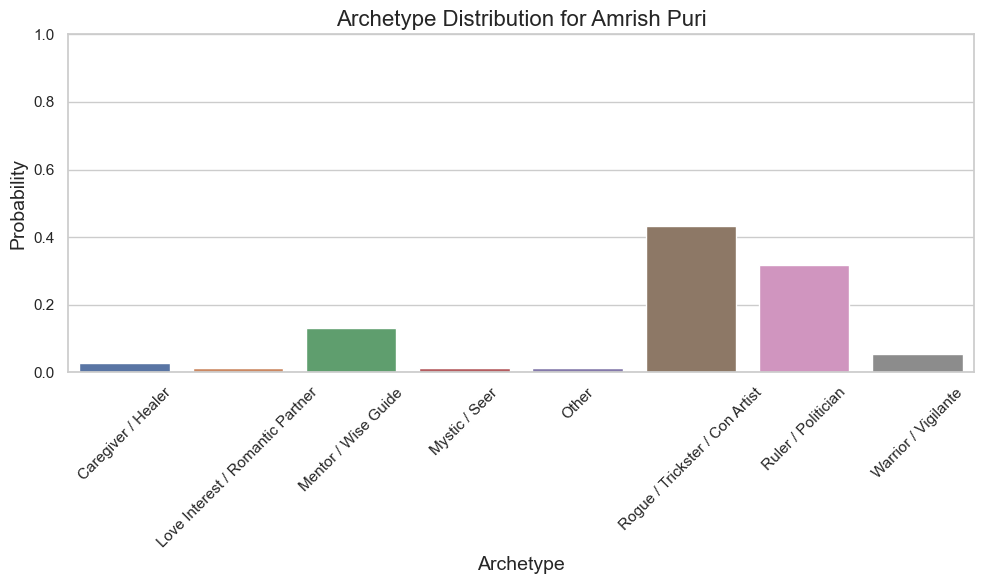

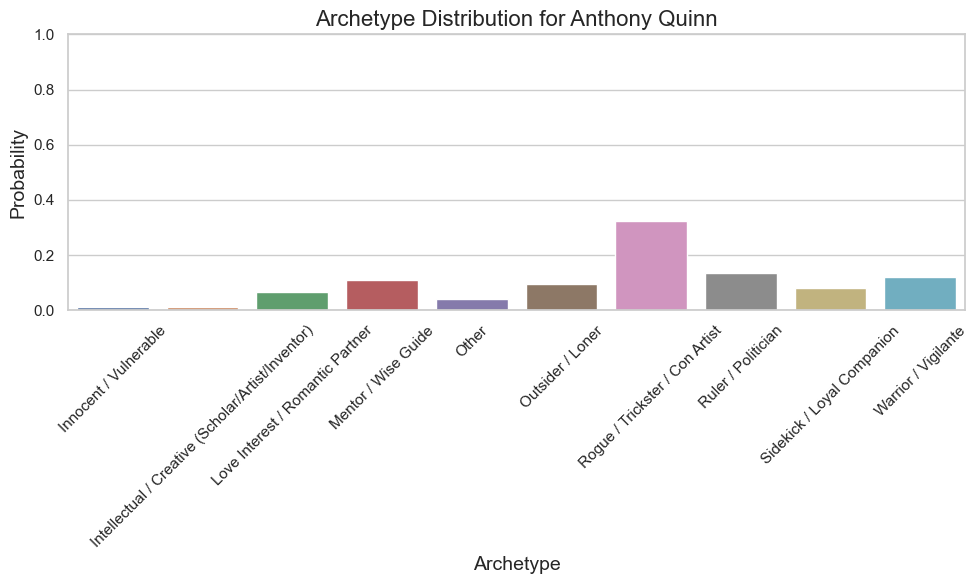

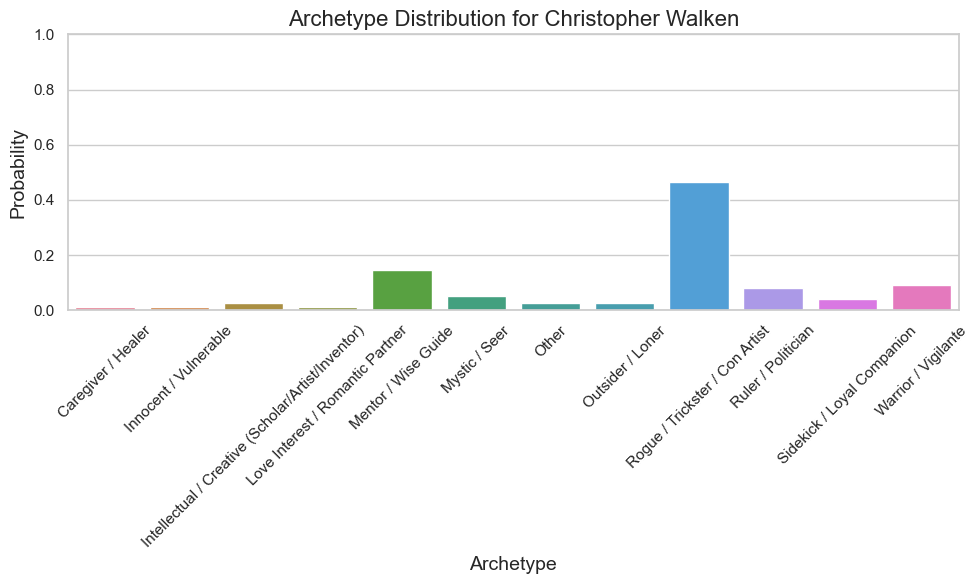

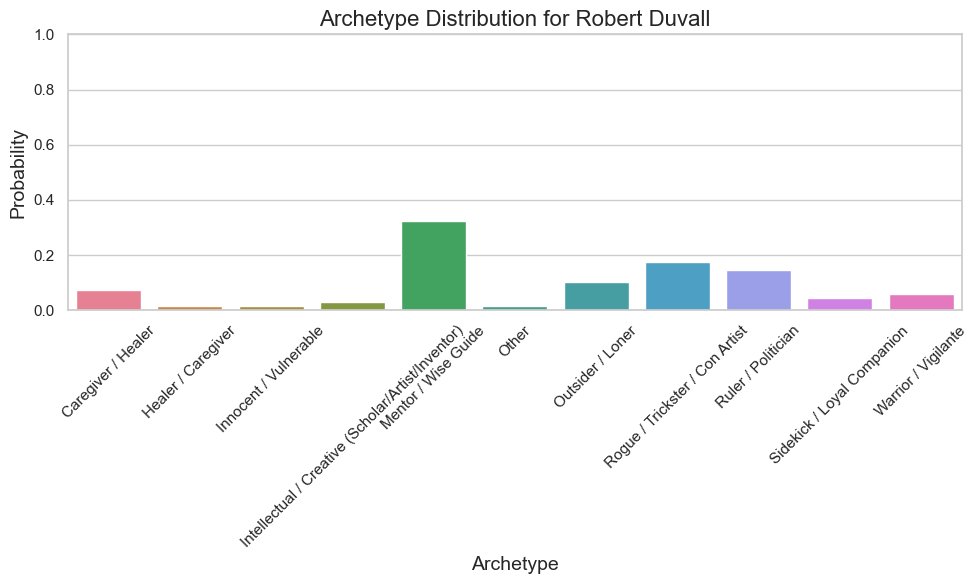

In [52]:
top_10_actors = actors_with_10_plus_roles['actor_name'].head(10).tolist()  # Get top 10 actors
for actor in top_10_actors:
    plot_archetype_distribution(actor, archetype_distribution)

By looking at these plots we clearly see that certain actors are more likely to be typecast into specific archetypes. Now let's use some of the statistical approaches and look at the results. For each actor let's define a metric of "probability to being typecasted to the specific (set of) archetypes" as the highest probability among the archetypes in the previous charts. Then let's see the distribution of this value for each actor and visualize it.

In [47]:
max_probabilities = (
    archetype_distribution
    .groupby('actor_name')['probability']
    .max()
    .reset_index()
)

max_probabilities.columns = ['actor_name', 'max_probability']
max_probabilities.head(10)

,actor_name,max_probability
0,A. J. Cook,0.200000
1,A.K Hangal,0.411765
2,Aamir Khan,0.360000
3,Aaron Eckhart,0.315789
4,Aaron Johnson,0.272727
5,Aarti Chhabria,0.600000
6,Aasif Mandvi,0.272727
7,Abbas,0.200000
8,Abhi Bhattacharya,0.200000
9,Abhishek Bachchan,0.428571


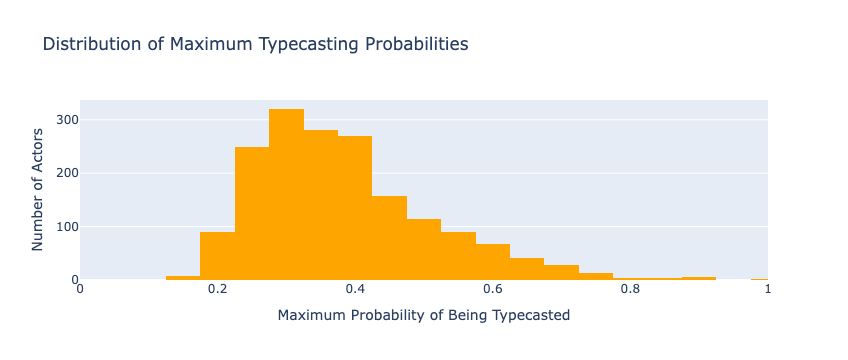

In [56]:
fig = px.histogram(max_probabilities, 
                   x='max_probability', 
                   nbins=20, 
                   title='Distribution of Maximum Typecasting Probabilities',
                   labels={'max_probability': 'Maximum Probability of Being Typecasted'},
                   color_discrete_sequence=['orange'])

fig.update_layout(
    xaxis_title='Maximum Probability of Being Typecasted',
    yaxis_title='Number of Actors',
    xaxis=dict(nticks=10, range=[0, 1]),
    yaxis_title_standoff=10
)

fig.show()

Let's analyze this distribution. First, let's look at the descriptive statistics

In [70]:
max_probabilities.describe()

,max_probability
count,1744.000000
mean,0.385056
std,0.129078
min,0.150000
25%,0.294118
50%,0.357143
75%,0.454545
max,1.000000


We can see that the mean is 0.39, meaning that on average 4 times out of 10 (almost a half of the times) actors got selected for the roles with the specific archetypes. However, this does not give us a clear understanding, so let's also perform the Chi-Square Test:

In [73]:
from scipy.stats import chi2_contingency

max_probabilities['binned'] = pd.cut(max_probabilities['max_probability'], bins=[0, 0.33, 0.66, 1], labels=['Low', 'Medium', 'High'])
contingency_table = pd.crosstab(max_probabilities['actor_name'], max_probabilities['binned'])


chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
print(f'Chi-square Statistic: {chi2_stat}, p-value: {p_value}, Degrees of Freedom: {dof}')

Chi-square Statistic: 3488.0000000000005, p-value: 0.48726319957658, Degrees of Freedom: 3486


Given the high p-value = 0.487 > 0.05 we conclude that there is no significant association (in this mathematical abstraction). In other words, the distribution of maximum probabilities categorized as 'Low', 'Medium', and 'High' does not significantly depend on the actors.
The possible explanation and further development could be that we define max_probability not as the maximum probability for the specific archetype, but take, for example, 3 archetypes with maximum probabilities, which I believe will give the positive answer for this question. Let us check the contingency table and then redefine the max_probability.

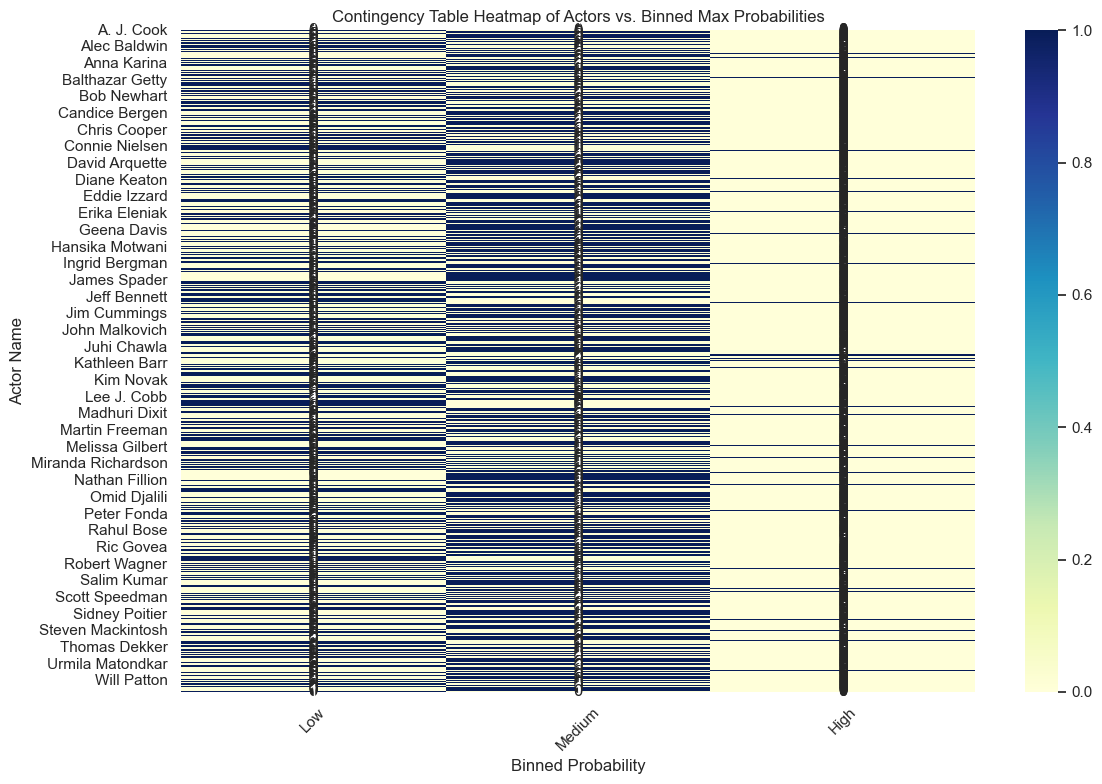

In [74]:
plt.figure(figsize=(12, 8))
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='YlGnBu', cbar=True)
plt.title('Contingency Table Heatmap of Actors vs. Binned Max Probabilities')
plt.xlabel('Binned Probability')
plt.ylabel('Actor Name')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [76]:
top_3_sum_probabilities = (
    archetype_distribution
    .groupby('actor_name')['probability']
    .apply(lambda x: x.nlargest(3).sum()) 
    .reset_index()
)

top_3_sum_probabilities.columns = ['actor_name', 'sum_top_3_probabilities']

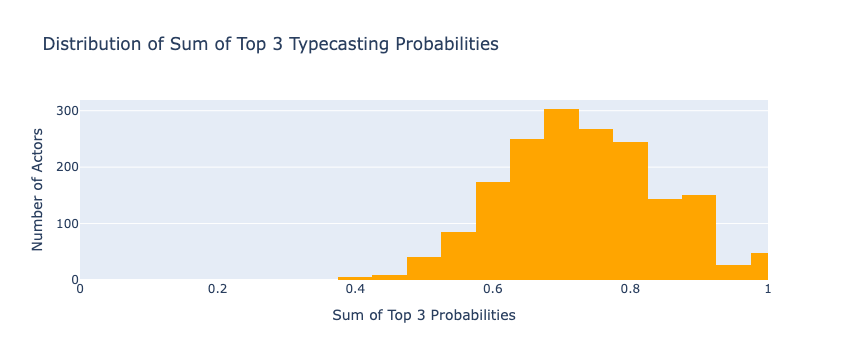

In [78]:
fig = px.histogram(top_3_sum_probabilities, 
                   x='sum_top_3_probabilities', 
                   nbins=20,
                   title='Distribution of Sum of Top 3 Typecasting Probabilities',
                   labels={'sum_top_3_probabilities': 'Sum of Top 3 Probabilities'},
                   color_discrete_sequence=['orange'])

fig.update_layout(
    xaxis_title='Sum of Top 3 Probabilities',
    yaxis_title='Number of Actors',
    xaxis=dict(nticks=10, range=[0, 1]), 
    yaxis_title_standoff=10
)

fig.show()

In [79]:
top_3_sum_probabilities.describe()

,sum_top_3_probabilities
count,1744.000000
mean,0.731918
std,0.116027
min,0.400000
25%,0.647059
50%,0.727273
75%,0.812500
max,1.000000


In [83]:
top_3_sum_probabilities['binned'] = pd.cut(
    top_3_sum_probabilities['sum_top_3_probabilities'],
    bins=[0, 0.33, 0.66, 1], 
    labels=['Low', 'Medium', 'High']
)

contingency_table = pd.crosstab(top_3_sum_probabilities['actor_name'], top_3_sum_probabilities['binned'])
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
print(f'Chi-square Statistic: {chi2_stat}, p-value: {p_value}, Degrees of Freedom: {dof}')

Chi-square Statistic: 1744.0, p-value: 0.4887414065286344, Degrees of Freedom: 1743


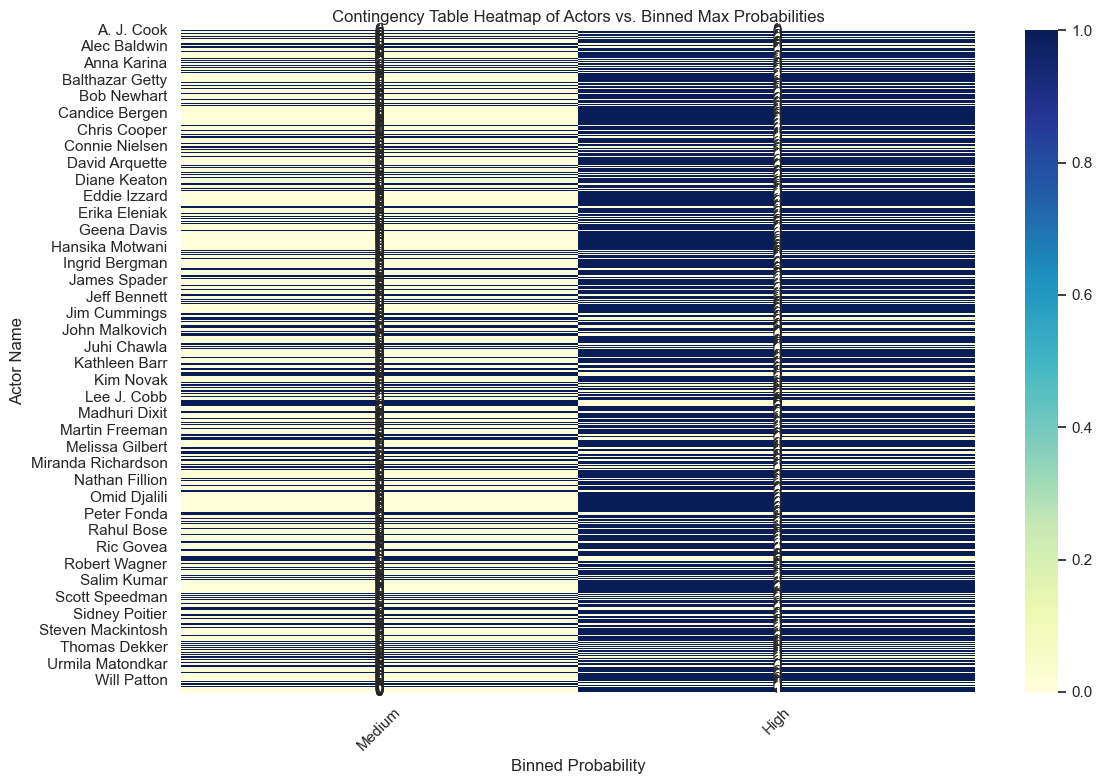

In [81]:
plt.figure(figsize=(12, 8))
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='YlGnBu', cbar=True)
plt.title('Contingency Table Heatmap of Actors vs. Binned Max Probabilities')
plt.xlabel('Binned Probability')
plt.ylabel('Actor Name')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Conclusion
Even though the Chi-square test didn't provide a positive answer, the answer to this question varies on different parameters. with the mean of the distribution being significant with any definition of max_probabilities we can conclude that the hypothesis is somewhat relevant.